# SET ENVIRONMENT

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import  loguniform, randint, uniform, reciprocal
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.svm import SVR
import klib

In [2]:
df_raw = pd.read_csv('../data/movies.csv')
df_raw.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   budget    6820 non-null   float64
 1   company   6820 non-null   object 
 2   country   6820 non-null   object 
 3   director  6820 non-null   object 
 4   genre     6820 non-null   object 
 5   gross     6820 non-null   float64
 6   name      6820 non-null   object 
 7   rating    6820 non-null   object 
 8   released  6820 non-null   object 
 9   runtime   6820 non-null   int64  
 10  score     6820 non-null   float64
 11  star      6820 non-null   object 
 12  votes     6820 non-null   int64  
 13  writer    6820 non-null   object 
 14  year      6820 non-null   int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


In [4]:
seed = 42

In [5]:
df = df_raw.copy()
df = df.sample(frac=1)
# replaces 0 by nans according to the description of the variable
df['budget'] = df['budget'].replace(0, np.nan)

In [6]:
# changes released variable  to datetime
df['released'] = pd.to_datetime(df['released'])
# adding month as a new categorical feature
df['month'] = df['released'].dt.month
df['month'] = df['month'].astype('str')

df['importance'] = df['score'] * df['votes']

In [7]:
df.isna().sum()

budget        2182
company          0
country          0
director         0
genre            0
gross            0
name             0
rating           0
released         0
runtime          0
score            0
star             0
votes            0
writer           0
year             0
month            0
importance       0
dtype: int64

In [8]:
N = 50
s_genre = df['genre'].value_counts()
s_genre = s_genre[s_genre>=N]
l_genre = s_genre.index

s_rating = df['rating'].value_counts()
s_rating = s_rating[s_rating>=N]
l_rating = s_rating.index

In [9]:
# df['gross'] = np.log(df['gross'])

In [10]:
df = df.loc[df['genre'].isin(l_genre)]
df = df.loc[df['rating'].isin(l_rating)]
df.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,month,importance
5801,6000000.0,Also Known As Pictures,USA,Brian Klugman,Drama,11494838.0,The Words,PG-13,2012-09-07,102,7.1,Bradley Cooper,64718,Brian Klugman,2012,9,459497.8
2850,NaN,De Fina-Cappa,UK,Stephen Frears,Drama,163810.0,The Hi-Lo Country,R,1999-01-22,114,6.1,Billy Crudup,3807,Max Evans,1998,1,23222.7
2962,NaN,Irish Screen,UK,Justin Kerrigan,Comedy,104257.0,Human Traffic,R,2000-05-05,99,7.1,John Simm,20316,Justin Kerrigan,1999,5,144243.6
962,NaN,Epic Productions,USA,Emilio Estevez,Action,16247964.0,Men at Work,PG-13,1990-08-24,98,5.9,Charlie Sheen,19392,Emilio Estevez,1990,8,114412.8
1761,8000000.0,Miramax,USA,Quentin Tarantino,Crime,107928762.0,Pulp Fiction,R,1994-10-14,154,8.9,John Travolta,1456787,Quentin Tarantino,1994,10,12965404.3


In [11]:
df_raw.columns

Index(['budget', 'company', 'country', 'director', 'genre', 'gross', 'name',
       'rating', 'released', 'runtime', 'score', 'star', 'votes', 'writer',
       'year'],
      dtype='object')

In [12]:
feat = ['gross','budget','genre','rating','score','month','runtime','year', 'votes', 'importance']
# feat = ['gross','budget','score','month','runtime','year', 'votes', 'importance']

df = df[feat]

In [13]:
df.dropna(inplace=True)

In [14]:
df.describe()

,gross,budget,score,runtime,year,votes,importance
count,4.536000e+03,4.536000e+03,4536.000000,4536.000000,4536.000000,4.536000e+03,4.536000e+03
mean,4.654958e+07,3.647951e+07,6.360472,107.682099,2002.552249,9.581363e+04,6.798642e+05
std,6.673212e+07,4.017500e+07,1.009680,18.074900,8.447302,1.490797e+05,1.211359e+06
min,3.090000e+02,6.000000e+03,1.500000,69.000000,1986.000000,1.830000e+02,8.418000e+02
25%,6.514777e+06,1.000000e+07,5.800000,96.000000,1996.000000,1.623525e+04,9.382838e+04
50%,2.416771e+07,2.300000e+07,6.400000,104.000000,2003.000000,4.424000e+04,2.749810e+05
75%,5.834823e+07,4.700000e+07,7.100000,117.000000,2010.000000,1.099908e+05,7.245408e+05
max,9.366622e+08,3.000000e+08,9.300000,280.000000,2016.000000,1.861666e+06,1.731349e+07


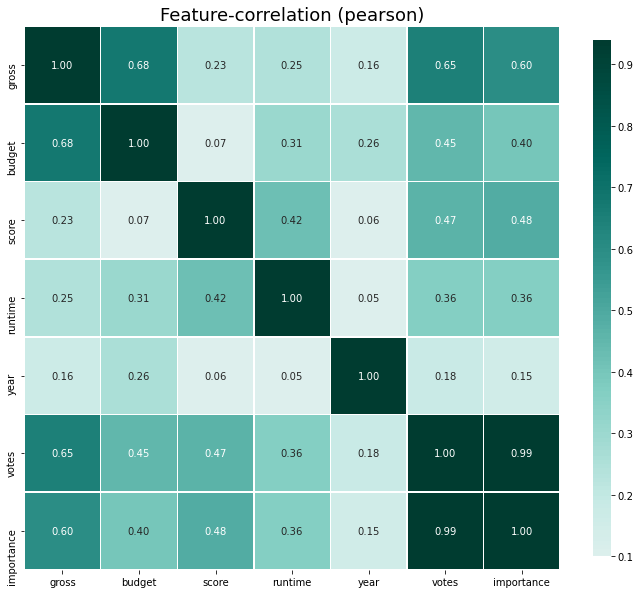

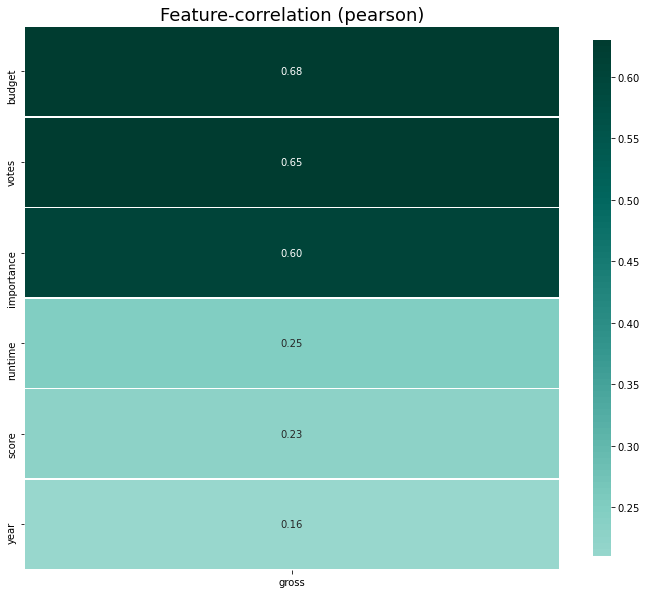

In [15]:
# correlation between variables
klib.corr_plot(df, mask=False);
klib.corr_plot(df, target='gross');

In [16]:
X = df.drop('gross', axis=1)
y = df['gross']

In [17]:
X.shape, y.shape

((4536, 9), (4536,))

In [18]:
X.columns

Index(['budget', 'genre', 'rating', 'score', 'month', 'runtime', 'year',
       'votes', 'importance'],
      dtype='object')

In [19]:
cat_cols = ['genre','rating','month']
# cat_cols = ['month']

cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer([
   ('cat', cat_pipe, cat_cols)
])

estimator = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor())
    
])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['genre', 'rating',
                                                   'month'])])),
                ('regressor', RandomForestRegressor())])

In [22]:
r2_score(y_test, estimator.predict(X_test))

0.2345207197489796

In [23]:
param_dist = {'regressor__n_estimators': randint(20, 500),
              'regressor__max_features': ['auto','sqrt'],
              'regressor__min_samples_split': randint(2,20),
              'regressor__min_samples_leaf': randint(1,10),
              'regressor__bootstrap': [True, False]
             }

In [24]:
random_search = RandomizedSearchCV(estimator, param_dist, n_iter=100, cv=3, scoring = ['r2','neg_mean_absolute_error'],
                                   refit='r2', n_jobs=-1, verbose=1)

In [25]:
random_search.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   32.2s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['genre',
                                                                                'rating',
                                                                                'month'])])),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'regressor__bootstrap': [True, False],
                                        'regressor__max_f

In [26]:
random_search.best_params_

{'regressor__bootstrap': False,
 'regressor__max_features': 'sqrt',
 'regressor__min_samples_leaf': 6,
 'regressor__min_samples_split': 14,
 'regressor__n_estimators': 154}

In [27]:
random_search.best_score_

0.2296321669058896

In [28]:
def ResultsRegressorGridSearch(gridsearch):
    
    print("Best parameters: {}".format(gridsearch.best_params_))

    mean_r2 = gridsearch.cv_results_['mean_test_r2'][gridsearch.best_index_]
    std_r2 = gridsearch.cv_results_['std_test_r2'][gridsearch.best_index_]

    mean_mae = gridsearch.cv_results_['mean_test_neg_mean_absolute_error'][gridsearch.best_index_]
    std_mae = gridsearch.cv_results_['std_test_neg_mean_absolute_error'][gridsearch.best_index_]

    print(f"R2: {mean_r2}, {std_r2}")
    print(f"MAE: {-mean_mae}, {std_mae}")
    
    return None

In [29]:
ResultsRegressorGridSearch(random_search)

Best parameters: {'regressor__bootstrap': False, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 6, 'regressor__min_samples_split': 14, 'regressor__n_estimators': 154}
R2: 0.2296321669058896, 0.027059875064963004
MAE: 36360285.52419517, 501552.2992778532


## SVR

In [30]:
X.dtypes

budget        float64
genre          object
rating         object
score         float64
month          object
runtime         int64
year            int64
votes           int64
importance    float64
dtype: object

In [31]:
X_train.columns

Index(['budget', 'genre', 'rating', 'score', 'month', 'runtime', 'year',
       'votes', 'importance'],
      dtype='object')

In [32]:
X_train.isna().sum()

budget        0
genre         0
rating        0
score         0
month         0
runtime       0
year          0
votes         0
importance    0
dtype: int64

In [33]:
cat_cols = ['genre','rating','month']
# cat_cols = ['month']

num_cols = ['budget','score','runtime','year','votes', 'importance']


cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])


preprocessing = ColumnTransformer([
   ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

estimator = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', SVR(kernel='linear'))
    
])

In [34]:
estimator.fit(X_train, y_train)
r2_score(y_test, estimator.predict(X_test))

-0.11450191874635718

In [35]:
param_dist = {
              'regressor__kernel': ['linear','rbf','poly'],
              'regressor__degree': randint(2,4),
              'regressor__gamma': ['scale','auto'],
              'regressor__C': reciprocal(0.1,100),
             }

random_search = RandomizedSearchCV(estimator, param_dist, n_iter=100, cv=3, scoring = ['r2','neg_mean_absolute_error'],
                                   refit='r2', n_jobs=-1, verbose=1)

In [36]:
random_search.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.5s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['genre',
                                                                                'rating',
                                                                                'month']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
     

In [37]:
random_search.best_params_

{'regressor__C': 98.92413776905252,
 'regressor__degree': 2,
 'regressor__gamma': 'scale',
 'regressor__kernel': 'linear'}

In [38]:
random_search.best_score_

-0.10579504011661922

In [39]:
ResultsRegressorGridSearch(random_search)

Best parameters: {'regressor__C': 98.92413776905252, 'regressor__degree': 2, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
R2: -0.10579504011661922, 0.011764108556961483
MAE: 38143877.666968875, 902441.8867252445


# FINAL